# Analyse préliminaire

## Import bibliothèque

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import stats_desc as st
from scipy.stats import chi2_contingency

## Chargement des datasets

In [160]:
# Load your dataset into a DataFrame
df_client = pd.read_csv("data/CLIENT.csv", sep = "|", dtype={'IDCLIENT':str, 'VIP': str})
df_ticket = pd.read_csv('data/ENTETES_TICKET_V4.csv', sep = "|", dtype={'IDTICKET':str, 'IDCLIENT' : str})
df_magasin = pd.read_csv('data/REF_MAGASIN.CSV', sep = "|",dtype={'LIBELLEDEPARTEMENT':str})




C:\Users\benja\AppData\Local\Temp\ipykernel_14264\2190855751.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_client = pd.read_csv("data/CLIENT.csv", sep = "|", dtype={'IDCLIENT':str, 'VIP': str})


In [137]:
df_client.head()

,IDCLIENT,CIVILITE,DATENAISSANCE,MAGASIN,DATEDEBUTADHESION,DATEREADHESION,DATEFINADHESION,VIP,CODEINSEE,PAYS
0,155891,MADAME,NaN,VLG,13/05/2005 0:00:00,4/04/2017 0:00:00,30/04/2018 0:00:00,0,74224,FR
1,156023,MONSIEUR,7/08/1966 0:00:00,VLG,14/05/2005 0:00:00,21/06/2014 0:00:00,30/06/2016 0:00:00,0,74189,FR
2,124203,MADAME,NaN,BEA,16/03/2005 0:00:00,12/10/2017 0:00:00,31/10/2018 0:00:00,0,63070,FR
3,156190,MADAME,24/07/1976 0:00:00,SUR,28/08/2006 0:00:00,24/05/2015 0:00:00,31/05/2016 0:00:00,0,92026,FR
4,144444,MONSIEUR,NaN,LAB,29/04/2006 0:00:00,18/12/2016 0:00:00,31/12/2017 0:00:00,0,31555,FR


## Transformation des variables

In [138]:
df_client['DATEDEBUTADHESION'] = pd.to_datetime(df_client['DATEDEBUTADHESION'], 
                                           format= '%d/%m/%Y %H:%M:%S')
df_client['DATEFINADHESION'] = pd.to_datetime(df_client['DATEFINADHESION'], 
                                             format='%d/%m/%Y %H:%M:%S')

df_ticket['TIC_TOTALTTC']=df_ticket['TIC_TOTALTTC'].str.replace(',','.')
df_ticket['TIC_TOTALTTC']=df_ticket['TIC_TOTALTTC'].astype('float')

## Construction du dataset

In [139]:
print(df_client.info())
print(df_ticket.info())
print(df_magasin.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845876 entries, 0 to 845875
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   IDCLIENT           845876 non-null  object        
 1   CIVILITE           845876 non-null  object        
 2   DATENAISSANCE      507902 non-null  object        
 3   MAGASIN            845876 non-null  object        
 4   DATEDEBUTADHESION  845876 non-null  datetime64[ns]
 5   DATEREADHESION     507816 non-null  object        
 6   DATEFINADHESION    845876 non-null  datetime64[ns]
 7   VIP                845876 non-null  object        
 8   CODEINSEE          818455 non-null  object        
 9   PAYS               845873 non-null  object        
dtypes: datetime64[ns](2), object(8)
memory usage: 64.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6714173 entries, 0 to 6714172
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------  

In [140]:
df_sommeticket = df_ticket.groupby(['IDCLIENT']).agg(Total_ticket=('TIC_TOTALTTC',"sum")).reset_index()
df_sommeticket.head()

,IDCLIENT,Total_ticket
0,10000,813.16
1,100002,249.41
2,100004,199.57
3,100006,1626.06
4,100008,332.50


In [141]:
df_general = df_client.merge(df_sommeticket, how = 'left', left_on = 'IDCLIENT', right_on = 'IDCLIENT')
df_general = df_general.merge(df_magasin[['CODESOCIETE','LIBELLEDEPARTEMENT']], how = 'left', left_on = 'MAGASIN', right_on = 'CODESOCIETE')
df_general = df_general.drop('CODESOCIETE', axis = 1)
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845876 entries, 0 to 845875
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   IDCLIENT            845876 non-null  object        
 1   CIVILITE            845876 non-null  object        
 2   DATENAISSANCE       507902 non-null  object        
 3   MAGASIN             845876 non-null  object        
 4   DATEDEBUTADHESION   845876 non-null  datetime64[ns]
 5   DATEREADHESION      507816 non-null  object        
 6   DATEFINADHESION     845876 non-null  datetime64[ns]
 7   VIP                 845876 non-null  object        
 8   CODEINSEE           818455 non-null  object        
 9   PAYS                845873 non-null  object        
 10  Total_ticket        770163 non-null  float64       
 11  LIBELLEDEPARTEMENT  845876 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(9)
memory usage: 83.9+ MB


## Analyse du dataset

### Proportion Initial de VIP avant cleaning

In [142]:
#Proportion VIP 
comptage = round((((df_general['VIP'] == '1').sum())/df_general.shape[0])*100,2)


print("la proportion de VIP est de {} %".format(comptage))

la proportion de VIP est de 13.06 %


 ### Nombre de lignes

In [143]:
Nb_ligne_init=df_general.shape[0]
print(Nb_ligne_init)

845876


 ### Détail des Valeurs manquantes

In [144]:
df_general.isna().sum()

IDCLIENT                   0
CIVILITE                   0
DATENAISSANCE         337974
MAGASIN                    0
DATEDEBUTADHESION          0
DATEREADHESION        338060
DATEFINADHESION            0
VIP                        0
CODEINSEE              27421
PAYS                       3
Total_ticket           75713
LIBELLEDEPARTEMENT         0
dtype: int64

### Statistique descriptif qualitatif

In [145]:
colonne_qualit=df_general.drop('Total_ticket',axis=1)
print(colonne_qualit.describe())
print(st.get_stats_quali(colonne_qualit))

C:\Users\benja\AppData\Local\Temp\ipykernel_14264\1117807420.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(colonne_qualit.describe())
C:\Users\benja\AppData\Local\Temp\ipykernel_14264\1117807420.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(colonne_qualit.describe())


       IDCLIENT CIVILITE      DATENAISSANCE MAGASIN    DATEDEBUTADHESION  \
count    845876   845876             507902  845876               845876   
unique   845876        6              27869      67                 6356   
top      155891   MADAME  1/10/1970 0:00:00     PRI  2001-03-01 00:00:00   
freq          1   454862                680   26935                10214   
first       NaN      NaN                NaN     NaN  1997-01-01 00:00:00   
last        NaN      NaN                NaN     NaN  2017-12-31 00:00:00   

           DATEREADHESION      DATEFINADHESION     VIP CODEINSEE    PAYS  \
count              507816               845876  845876    818455  845873   
unique               2860                  161       2     24442      48   
top     8/04/2017 0:00:00  2018-05-31 00:00:00       0     13001      FR   
freq                 2149                56297  735425      9174  827365   
first                 NaN  2016-01-21 00:00:00     NaN       NaN     NaN   
last       

g:\Mon Drive\cours benjamin\ESG Paris\Cours\Semestre 2\Machine learning\Machine learning - Projet\Projet Machine learning\stats_desc.py:61: FutureWarning: ['DATENAISSANCE', 'DATEREADHESION', 'CODEINSEE', 'PAYS'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stats1 = df.agg(['nunique', 'min', 'max']).transpose()


                             dtype  nunique                  min  \
IDCLIENT                    object   845876                10000   
CIVILITE                    object        6               MADAME   
DATENAISSANCE               object  27869.0                  NaN   
MAGASIN                     object       67                  ALB   
DATEDEBUTADHESION   datetime64[ns]     6356  1997-01-01 00:00:00   
DATEREADHESION              object   2860.0                  NaN   
DATEFINADHESION     datetime64[ns]      161  2016-01-21 00:00:00   
VIP                         object        2                    0   
CODEINSEE                   object  24442.0                  NaN   
PAYS                        object     48.0                  NaN   
LIBELLEDEPARTEMENT          object       34                   01   

                                    max   taux_na  
IDCLIENT                          99999  0.000000  
CIVILITE                       monsieur  0.000000  
DATENAISSANCE              

### Statistique descriptif quantitatif

In [146]:
colonne_quanti=df_general[['Total_ticket']]
print(colonne_quanti.describe())
print(st.get_stats_quanti(colonne_quanti))

        Total_ticket
count  770163.000000
mean      506.980242
std       691.570828
min     -1187.880000
25%       131.720000
50%       281.950000
75%       616.235000
max     75593.440000
                dtype      min       max        mean         std  median  \
Total_ticket  float64 -1187.88  75593.44  506.980242  691.570828  281.95   

               taux_na  taux_var  
Total_ticket  0.089508  1.364098  


In [147]:
print('le quantile à 99 % est {}:'.format(colonne_quanti.quantile(0.99)))

le quantile à 99 % est Total_ticket    3240.0728
Name: 0.99, dtype: float64:


#### Analyse et cleaning à faire

- 6 valeurs uniques dans civilite à réduire à 2 
- Supprimer la colonne manquante datenaissance car trop de valeur manquante et valeur (45%)
- tranformer date readhesion en booléen
- Supprimer la colonne manquante code insee car valeur manquante et fait doublon avec département magasin
- Recadrer les valeurs de tic_total (suppresion valeur inf à 0 et supérieur à 4000)
- récupérer juste mois et année pour les dates

 ## Cleaning du dataset

### Transformation civilite

In [148]:
df_general['CIVILITE'].unique()

array(['MADAME', 'MONSIEUR', 'monsieur', 'madame', 'Mme', 'Mr'],
      dtype=object)

In [149]:
list_to_replace =['Mr','monsieur']
df_general['CIVILITE'].replace(list_to_replace, 'MONSIEUR', inplace=True)
list_to_replace =['Mme','madame']
df_general['CIVILITE'].replace(list_to_replace, 'MADAME', inplace=True)
df_general['CIVILITE'].unique()

array(['MADAME', 'MONSIEUR'], dtype=object)

### Transformation date en mois /année

In [150]:
df_general['Mois_DATEDEBUTADHESION']= df_general['DATEDEBUTADHESION'].dt.month
df_general['Annee_DATEDEBUTADHESION']= df_general['DATEDEBUTADHESION'].dt.year
df_general['Mois_DATEFINADHESION']= df_general['DATEFINADHESION'].dt.month
df_general['Annee_DATEFINADHESION']= df_general['DATEFINADHESION'].dt.year
df_general=df_general.drop('DATEFINADHESION',axis=1)
df_general=df_general.drop('DATEDEBUTADHESION',axis=1)

### Transformation readhesion en binaire

In [151]:

df_general['DATEREADHESION'] = df_general['DATEREADHESION'].fillna(0)
df_general['DATEREADHESION'] = df_general['DATEREADHESION'].apply(lambda x: 1 if x != 0 else 0)
print(df_general['DATEREADHESION'].value_counts())

1    507816
0    338060
Name: DATEREADHESION, dtype: int64


### Suppression colonne naissance et code INSEE

In [152]:
df_general=df_general.drop('DATENAISSANCE',axis=1)
df_general=df_general.drop('CODEINSEE',axis=1)

### Redimensionnement total ticket

In [153]:
filtre = (df_general['Total_ticket'] > 0 )& (df_general['Total_ticket'] < 4000)
df_general=df_general[filtre]

### Supression Valeurs manquantes

In [154]:
df_general= df_general.dropna()

### Proportion ligne perdu 

In [155]:
Ligne_perdu= round(((Nb_ligne_init-df_general.shape[0])/Nb_ligne_init)*100,2)
print(Ligne_perdu)


9.48


### Proportion VIP après Cleaning

In [159]:
#Proportion VIP 
comptage = round((((df_general['VIP'] == '1').sum())/df_general.shape[0])*100,2)

print("la proportion de VIP est de {} %".format(comptage))

la proportion de VIP est de 13.89 %


## Etude des Corrélations

### Corrélation Quali X Quali

In [157]:
colonne_qualit=df_general.drop('Total_ticket',axis=1)
# Sélectionner la colonne fixe
colonne_fixe = colonne_qualit['VIP']

# Parcourir toutes les autres colonnes
for nom_colonne in colonne_qualit.columns:
    if nom_colonne != 'VIP':
        # Sélectionner la colonne à analyser
        colonne_analyse = colonne_qualit[nom_colonne]
        
        # Créer un tableau de contingence entre les deux colonnes
        table_contingence = pd.crosstab(colonne_fixe, colonne_analyse)
        
        # Effectuer le test Chi2 et afficher le résultat
        stat, p, dof, expected = chi2_contingency(table_contingence)
        print(f'Corrélation chi2 entre {colonne_fixe.name} et {nom_colonne}: p = {p}')

Corrélation chi2 entre VIP et IDCLIENT: p = 0.49946268602311394
Corrélation chi2 entre VIP et CIVILITE: p = 8.966880751254814e-17
Corrélation chi2 entre VIP et MAGASIN: p = 0.0
Corrélation chi2 entre VIP et DATEREADHESION: p = 0.0
Corrélation chi2 entre VIP et PAYS: p = 7.026636357105466e-53
Corrélation chi2 entre VIP et LIBELLEDEPARTEMENT: p = 0.0
Corrélation chi2 entre VIP et Mois_DATEDEBUTADHESION: p = 1.4901225991437774e-306
Corrélation chi2 entre VIP et Annee_DATEDEBUTADHESION: p = 0.0
Corrélation chi2 entre VIP et Mois_DATEFINADHESION: p = 0.0
Corrélation chi2 entre VIP et Annee_DATEFINADHESION: p = 0.0


### Corrélation Quali X Quanti

<AxesSubplot: xlabel='VIP', ylabel='Total_ticket'>

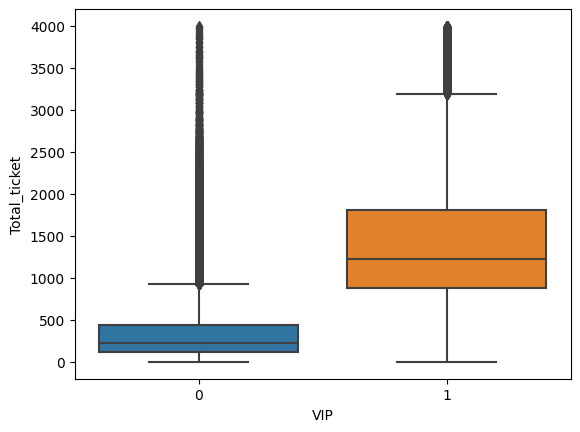

In [158]:
sns.boxplot(x=df_general['VIP'],y=df_general['Total_ticket'],data=df_general)